### IMDB Benchmarking
This notebook trains and evaluates different language representations and classification models on the IMDB movie review dataset. The dataset contains 50,000 highily polarized reviews of movies which is labeled as positive or negative. State of the art models currently have an accuracy of ~91 - 96 %, according to [nlpprogress.com](http://nlpprogress.com/english/sentiment_analysis.html).

In [56]:
import pandas as pd
import numpy as np
import seaborn as sn
import os
import matplotlib.pyplot as plt
from pathlib import Path
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn import svm
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Embedding, GRU, Bidirectional, Lambda
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm, trange

#### Load the IMDB data as raw text and labels

In [2]:
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

imdb_path = ONEDRIVE_PATH / "Benchmark Datasets/IMDB Dataset.csv"
glove_path = ONEDRIVE_PATH / "Benchmark Datasets/glove_embeddings.npy"
lengths_path = ONEDRIVE_PATH / "Benchmark Datasets/glove_lengths.npy"
imdb = pd.read_csv(imdb_path)
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### Vectorize the reviews using GloVe
Remove line breaks and vectorize the text using pre-trained GloVe-embeddings. The reviews are tokenized into words, and a vector of length 300 is constructed by the elementwise average of the GloVe-embeddings for one review. 

In [3]:
# Remove single line breaks (<br />)
for i in range(len(imdb)):
    imdb.iloc[i]['review'] = imdb.iloc[i]['review'].replace('<br />', ' ')

In [4]:
# Tokenize the text data 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(imdb['review'])
word_index = tokenizer.word_index

In [5]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300)) # Need one extra row since '0' is not an index
glove_path = ONEDRIVE_PATH / "Embeddings\GloVe\glove.42B.300d\glove.42B.300d.txt"
words_found = 0
f = open(glove_path,'r', encoding='UTF-8')
for line in f:
    splitLine = line.split()
    word = splitLine[0]
    if word in word_index.keys():
        words_found += 1
        embedding_matrix[word_index[word]] = np.array([float(val) for val in splitLine[1:]])
print("Done.",words_found,"words loaded!")

Done. 88481 words loaded!


In [16]:
if os.path.exists(glove_path):
    x = np.load(glove_path)
    rev_lengths = np.load(lengths_path)
    print("Embeddings loaded from file. ")
else:
    x = np.zeros((50000, 300))
    rev_lengths = np.zeros((50000))  # Record the length of every review to determine suitable maxlength for sequential data. 
    for i,review in tqdm(enumerate(imdb['review'])):
        tokenized_review = tokenizer.texts_to_sequences(word_tokenize(review))
        temp_array = np.zeros((300))
        n_words = 0
        rev_lengths[i] = len(tokenized_review)
        for word in tokenized_review:     
            if len(word) == 1:
                temp_array += embedding_matrix[word[0]]
                n_words += 1
        x[i] = temp_array / n_words
    np.save(glove_path, x)
    np.save(lengths_path, rev_lengths)

Embeddings loaded from file. 


In [17]:
# Divide into training and test set. The data is already shuffled. 
x_train = x[:25000]
x_test = x[25000:]

# Assign labels to variables for convenience
y = np.zeros((50000))
for i in trange(len(y)): 
    if imdb.iloc[i]['sentiment'] == 'positive':
        y[i] = 1
        
y_train = y[:25000]
y_test = y[25000:]

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:12<00:00, 4135.95it/s]


In [18]:
# Sanity check of shapes and label balance
print("Shape of training data:",x_train.shape)
print("Shape of test data:",x_test.shape)
print("Ratio positive reviews in training data:",np.sum(y_train) / len(y_train))
print("Ratio positive reviews in test data:",np.sum(y_test) / len(y_test))

Shape of training data: (25000, 300)
Shape of test data: (25000, 300)
Ratio positive reviews in training data: 0.49896
Ratio positive reviews in test data: 0.50104


#### Vectorize sequences using GloVe
We'll also try a recurrent approach with sequences as input. Instead of taking the average of the GloVe-embedding in one review, a sequence of word indices is fed into an embedding layer where the embeddings are initialized as pretrained GloVe-embeddings. However, using all of the words in the vocabulary gives a too slow model so we have to re-tokenize with a restricted vocabulary size. We'll also restrict the maximum word length from oen review to cover the majority of the training samples without being too inefficient. 

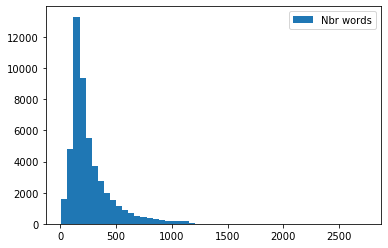

In [19]:
plt.hist(rev_lengths,50,label='Nbr words')
plt.legend()
plt.show() 

A maximum sentence length of 500 seems reasonable to cover the majority. Furthermore, we restrict the size of the vocabulary to make the task computationally feasible. 

In [26]:
sequential_path = ONEDRIVE_PATH / "Benchmark Datasets/glove_seq.npy"
embedding_path = ONEDRIVE_PATH / "Benchmark Datasets/glove_emb_mat.npy"

# Tokenize the text data 
maxlen = 500
# Restrict size of the vocabulary
vocab_size = 5000
if os.path.exists(sequential_path): 
    x_padded = np.load(sequential_path)
    trainable_embeddings = np.load(embedding_path)
    print("Loaded previously calculated data.")
else: 
    restricted_tokenizer = Tokenizer(num_words=vocab_size)
    restricted_tokenizer.fit_on_texts(imdb['review'])
    x_restr = restricted_tokenizer.texts_to_sequences(imdb['review'])
    # Pad the data with zeroes so all samples are of equal length
    x_padded = pad_sequences(x_restr,maxlen=maxlen)
    
    # Create a new embedding matrix for the restricted vocabulary ('embedding_matrix' includes the full vocaabulary)
    trainable_embeddings = np.zeros((vocab_size + 1, 300))    
    for i,word in enumerate(list(restricted_tokenizer.word_index.keys())[:vocab_size]):
        trainable_embeddings[i] = embedding_matrix[word_index[word]]
    np.save(sequential_path, x_padded)
    np.save(embedding_path, trainable_embeddings)
# Partition into training and test set
x_train_pad = x_padded[:25000]
x_test_pad = x_padded[25000:]

Loaded previously calculated data.


In [27]:
def plot_results(model,x_test, y_test,save=False, name=''):
    y_test_preds = model.predict(x_test)
    print(classification_report(y_test, y_test_preds))
    print("Test accuracy:",model.score(x_test, y_test))
    plot_confusion_matrix(model,x_test,y_test)
    if save:
        plt.savefig("Figs GloVe/" + name + "confmat.jpg")
    plt.show()
    
def plot_results_nn(history, model,x_test, y_test,save=False, name=''):
    plt.subplot(121)
    plt.plot(history.history['loss'],label='Loss')
    plt.plot(history.history['val_loss'],label='Val loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['acc'],label='Acc')
    plt.plot(history.history['val_acc'],label='Val acc')
    plt.legend()
    if save:
        plt.savefig("Figs GloVe/" + name + "history.jpg")
    plt.show() 
    y_test_pred = np.round(model.predict(x_test))
    plt.subplot(121)
    plt.bar([0,1],[np.sum(y_test == 0), np.sum(y_test == 1)], label='Actual test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.subplot(122)
    plt.bar([0,1],[np.sum(y_test_pred == 0), np.sum(y_test_pred == 1)], label='Pred test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.show()
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    if save: 
        plt.savefig("Figs GloVe/" + name + "confmat.jpg")
    plt.show()
    print(classification_report(y_test, y_test_pred))
    print("Test accuracy:",sum((np.transpose(y_test_pred) == y_test)[0]) / len(y_test))

### Logistic Regression with GloVe

              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85     12474
         1.0       0.85      0.85      0.85     12526

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Test accuracy: 0.85224


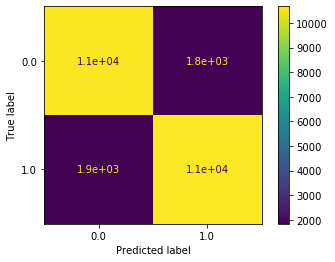

In [28]:
# Logistic regression
logreg = LogisticRegression(random_state=0,max_iter=10000).fit(x_train, y_train)
plot_results(logreg,x_test, y_test,save=True,name='logreg')

### Support Vector Machine with GloVe

              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84     12474
         1.0       0.84      0.84      0.84     12526

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Test accuracy: 0.84068


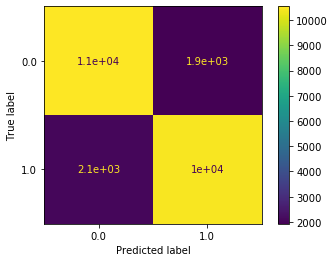

In [16]:
svm_clf = svm.SVC().fit(x_train, y_train)
plot_results(svm_clf, x_test, y_test,save=True,name='svm')

### Random Forest with GloVe

In [ ]:
rf_param_grid = dict(max_depth=[None, 10, 50],
                  n_estimators=[1000, 2500, 5000])

rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=1, 
                       cv=3, 
                       scoring='accuracy',
                       verbose=10)
rf_grid_result = rf_grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train, y_train)
plot_results(randomforest,x_test, y_test,save=True,name='rf_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] max_depth=None, n_estimators=1000 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... max_depth=None, n_estimators=1000, score=0.810, total= 9.4min
[CV] max_depth=None, n_estimators=1000 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.4min remaining:    0.0s


[CV] ... max_depth=None, n_estimators=1000, score=0.801, total= 9.4min
[CV] max_depth=None, n_estimators=1000 ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 18.8min remaining:    0.0s


[CV] ... max_depth=None, n_estimators=1000, score=0.803, total= 8.8min
[CV] max_depth=None, n_estimators=2500 ...............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 27.6min remaining:    0.0s


[CV] ... max_depth=None, n_estimators=2500, score=0.809, total=20.9min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 48.6min remaining:    0.0s


[CV] max_depth=None, n_estimators=2500 ...............................
[CV] ... max_depth=None, n_estimators=2500, score=0.803, total=15.8min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 64.4min remaining:    0.0s


[CV] max_depth=None, n_estimators=2500 ...............................
[CV] ... max_depth=None, n_estimators=2500, score=0.808, total=15.9min
[CV] max_depth=None, n_estimators=5000 ...............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 80.3min remaining:    0.0s


[CV] ... max_depth=None, n_estimators=5000, score=0.809, total=20.3min
[CV] max_depth=None, n_estimators=5000 ...............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 100.5min remaining:    0.0s


[CV] ... max_depth=None, n_estimators=5000, score=0.803, total=18.0min
[CV] max_depth=None, n_estimators=5000 ...............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 118.6min remaining:    0.0s


[CV] ... max_depth=None, n_estimators=5000, score=0.807, total=20.2min
[CV] max_depth=None, n_estimators=7500 ...............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 138.8min remaining:    0.0s


[CV] ... max_depth=None, n_estimators=7500, score=0.811, total=25.5min
[CV] max_depth=None, n_estimators=7500 ...............................
[CV] ... max_depth=None, n_estimators=7500, score=0.803, total=25.2min
[CV] max_depth=None, n_estimators=7500 ...............................
[CV] ... max_depth=None, n_estimators=7500, score=0.808, total=25.0min
[CV] max_depth=10, n_estimators=1000 .................................
[CV] ..... max_depth=10, n_estimators=1000, score=0.802, total= 2.4min
[CV] max_depth=10, n_estimators=1000 .................................
[CV] ..... max_depth=10, n_estimators=1000, score=0.795, total= 2.4min
[CV] max_depth=10, n_estimators=1000 .................................
[CV] ..... max_depth=10, n_estimators=1000, score=0.801, total= 2.4min
[CV] max_depth=10, n_estimators=2500 .................................
[CV] ..... max_depth=10, n_estimators=2500, score=0.804, total= 6.1min
[CV] max_depth=10, n_estimators=2500 .................................
[CV] .

### Neural Network - GloVe embeddings as pre-processing layer

In [57]:
def create_model_ff(nodes1=100, nodes2=50, dropout_rate=0.3, optimizer='rmsprop', learning_rate=0.001):
    if optimizer.lower() == 'rmsprop': 
        optimizer = RMSprop(learning_rate = learning_rate)
    elif optimizer.lower() == 'adam':
        optimizer = Adam(learning_rate = learning_rate)
    model = Sequential() 
    if nodes1 == 0: 
        model.add(Dense(1, input_shape=x_train.shape[1:], activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model 
    model.add(Dense(nodes1, input_shape=x_train.shape[1:]))
    model.add(Dropout(dropout_rate))
    if nodes2 == 0: 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model
    model.add(Dense(nodes2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    return model 

In [58]:
model = KerasClassifier(build_fn=create_model_ff, verbose=0)
# define the grid search parameters
batch_size = [4, 8]
epochs = [3]
nodes1 = [0, 50, 100, 250, 500]
nodes2 = [0, 50, 100, 250, 500] # 0 implies only one hidden layer 
dropout_rates = [0.1, 0.3, 0.5]
learning_rates = [1e-3, 1e-4, 1e-5]
optimizers = ['RMSprop','Adam']
nn_param_grid = dict(batch_size=batch_size,
                     epochs=epochs,
                     nodes1=nodes1,
                     nodes2=nodes2,
                     dropout_rate=dropout_rates,
                     learning_rate=learning_rates,
                     optimizer=optimizers)
nn_grid = RandomizedSearchCV(estimator=model,
                             param_distributions=nn_param_grid,
                             n_iter=50,
                             n_jobs=1,
                             cv=3,
                             scoring='accuracy',
                             verbose=10)

nn_grid_result = nn_grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (nn_grid_result.best_score_, nn_grid_result.best_params_))
means = nn_grid_result.cv_results_['mean_test_score']
stds = nn_grid_result.cv_results_['std_test_score']
params = nn_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] optimizer=Adam, nodes2=0, nodes1=100, learning_rate=1e-05, epochs=3, dropout_rate=0.1, batch_size=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  optimizer=Adam, nodes2=0, nodes1=100, learning_rate=1e-05, epochs=3, dropout_rate=0.1, batch_size=8, score=0.729, total=  23.9s
[CV] optimizer=Adam, nodes2=0, nodes1=100, learning_rate=1e-05, epochs=3, dropout_rate=0.1, batch_size=8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.8s remaining:    0.0s


[CV]  optimizer=Adam, nodes2=0, nodes1=100, learning_rate=1e-05, epochs=3, dropout_rate=0.1, batch_size=8, score=0.706, total=  21.5s
[CV] optimizer=Adam, nodes2=0, nodes1=100, learning_rate=1e-05, epochs=3, dropout_rate=0.1, batch_size=8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.3s remaining:    0.0s


[CV]  optimizer=Adam, nodes2=0, nodes1=100, learning_rate=1e-05, epochs=3, dropout_rate=0.1, batch_size=8, score=0.715, total=  21.7s
[CV] optimizer=Adam, nodes2=100, nodes1=500, learning_rate=1e-05, epochs=3, dropout_rate=0.3, batch_size=4 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


[CV]  optimizer=Adam, nodes2=100, nodes1=500, learning_rate=1e-05, epochs=3, dropout_rate=0.3, batch_size=4, score=0.797, total=  56.3s
[CV] optimizer=Adam, nodes2=100, nodes1=500, learning_rate=1e-05, epochs=3, dropout_rate=0.3, batch_size=4 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s


[CV]  optimizer=Adam, nodes2=100, nodes1=500, learning_rate=1e-05, epochs=3, dropout_rate=0.3, batch_size=4, score=0.779, total=  56.6s
[CV] optimizer=Adam, nodes2=100, nodes1=500, learning_rate=1e-05, epochs=3, dropout_rate=0.3, batch_size=4 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.0min remaining:    0.0s


[CV]  optimizer=Adam, nodes2=100, nodes1=500, learning_rate=1e-05, epochs=3, dropout_rate=0.3, batch_size=4, score=0.787, total=  56.9s
[CV] optimizer=RMSprop, nodes2=250, nodes1=250, learning_rate=1e-05, epochs=3, dropout_rate=0.5, batch_size=8 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.9min remaining:    0.0s


[CV]  optimizer=RMSprop, nodes2=250, nodes1=250, learning_rate=1e-05, epochs=3, dropout_rate=0.5, batch_size=8, score=0.728, total=  46.0s
[CV] optimizer=RMSprop, nodes2=250, nodes1=250, learning_rate=1e-05, epochs=3, dropout_rate=0.5, batch_size=8 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.7min remaining:    0.0s


[CV]  optimizer=RMSprop, nodes2=250, nodes1=250, learning_rate=1e-05, epochs=3, dropout_rate=0.5, batch_size=8, score=0.706, total=  50.3s
[CV] optimizer=RMSprop, nodes2=250, nodes1=250, learning_rate=1e-05, epochs=3, dropout_rate=0.5, batch_size=8 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.6min remaining:    0.0s


[CV]  optimizer=RMSprop, nodes2=250, nodes1=250, learning_rate=1e-05, epochs=3, dropout_rate=0.5, batch_size=8, score=0.726, total=  50.0s
[CV] optimizer=Adam, nodes2=100, nodes1=250, learning_rate=0.001, epochs=3, dropout_rate=0.3, batch_size=8 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  6.4min remaining:    0.0s


[CV]  optimizer=Adam, nodes2=100, nodes1=250, learning_rate=0.001, epochs=3, dropout_rate=0.3, batch_size=8, score=0.837, total=  33.4s
[CV] optimizer=Adam, nodes2=100, nodes1=250, learning_rate=0.001, epochs=3, dropout_rate=0.3, batch_size=8 
[CV]  optimizer=Adam, nodes2=100, nodes1=250, learning_rate=0.001, epochs=3, dropout_rate=0.3, batch_size=8, score=0.843, total=  34.1s
[CV] optimizer=Adam, nodes2=100, nodes1=250, learning_rate=0.001, epochs=3, dropout_rate=0.3, batch_size=8 
[CV]  optimizer=Adam, nodes2=100, nodes1=250, learning_rate=0.001, epochs=3, dropout_rate=0.3, batch_size=8, score=0.838, total=  35.0s
[CV] optimizer=RMSprop, nodes2=0, nodes1=50, learning_rate=0.001, epochs=3, dropout_rate=0.5, batch_size=8 
[CV]  optimizer=RMSprop, nodes2=0, nodes1=50, learning_rate=0.001, epochs=3, dropout_rate=0.5, batch_size=8, score=0.846, total=  19.9s
[CV] optimizer=RMSprop, nodes2=0, nodes1=50, learning_rate=0.001, epochs=3, dropout_rate=0.5, batch_size=8 
[CV]  optimizer=RMSprop,

[CV]  optimizer=Adam, nodes2=500, nodes1=50, learning_rate=1e-05, epochs=3, dropout_rate=0.3, batch_size=4, score=0.702, total= 1.1min
[CV] optimizer=Adam, nodes2=500, nodes1=50, learning_rate=1e-05, epochs=3, dropout_rate=0.3, batch_size=4 
[CV]  optimizer=Adam, nodes2=500, nodes1=50, learning_rate=1e-05, epochs=3, dropout_rate=0.3, batch_size=4, score=0.728, total= 1.1min
[CV] optimizer=Adam, nodes2=100, nodes1=500, learning_rate=0.001, epochs=3, dropout_rate=0.3, batch_size=8 
[CV]  optimizer=Adam, nodes2=100, nodes1=500, learning_rate=0.001, epochs=3, dropout_rate=0.3, batch_size=8, score=0.809, total=  49.7s
[CV] optimizer=Adam, nodes2=100, nodes1=500, learning_rate=0.001, epochs=3, dropout_rate=0.3, batch_size=8 
[CV]  optimizer=Adam, nodes2=100, nodes1=500, learning_rate=0.001, epochs=3, dropout_rate=0.3, batch_size=8, score=0.839, total=  51.7s
[CV] optimizer=Adam, nodes2=100, nodes1=500, learning_rate=0.001, epochs=3, dropout_rate=0.3, batch_size=8 
[CV]  optimizer=Adam, nodes

[CV]  optimizer=RMSprop, nodes2=0, nodes1=50, learning_rate=1e-05, epochs=3, dropout_rate=0.3, batch_size=4, score=0.711, total=  53.6s
[CV] optimizer=Adam, nodes2=250, nodes1=500, learning_rate=0.001, epochs=3, dropout_rate=0.1, batch_size=4 
[CV]  optimizer=Adam, nodes2=250, nodes1=500, learning_rate=0.001, epochs=3, dropout_rate=0.1, batch_size=4, score=0.851, total= 2.1min
[CV] optimizer=Adam, nodes2=250, nodes1=500, learning_rate=0.001, epochs=3, dropout_rate=0.1, batch_size=4 
[CV]  optimizer=Adam, nodes2=250, nodes1=500, learning_rate=0.001, epochs=3, dropout_rate=0.1, batch_size=4, score=0.804, total= 2.1min
[CV] optimizer=Adam, nodes2=250, nodes1=500, learning_rate=0.001, epochs=3, dropout_rate=0.1, batch_size=4 
[CV]  optimizer=Adam, nodes2=250, nodes1=500, learning_rate=0.001, epochs=3, dropout_rate=0.1, batch_size=4, score=0.835, total= 2.3min
[CV] optimizer=Adam, nodes2=50, nodes1=500, learning_rate=1e-05, epochs=3, dropout_rate=0.5, batch_size=8 
[CV]  optimizer=Adam, nod

[CV]  optimizer=RMSprop, nodes2=500, nodes1=500, learning_rate=1e-05, epochs=3, dropout_rate=0.1, batch_size=4, score=0.818, total= 3.8min
[CV] optimizer=RMSprop, nodes2=500, nodes1=500, learning_rate=1e-05, epochs=3, dropout_rate=0.1, batch_size=4 
[CV]  optimizer=RMSprop, nodes2=500, nodes1=500, learning_rate=1e-05, epochs=3, dropout_rate=0.1, batch_size=4, score=0.802, total= 3.7min
[CV] optimizer=RMSprop, nodes2=500, nodes1=500, learning_rate=1e-05, epochs=3, dropout_rate=0.1, batch_size=4 
[CV]  optimizer=RMSprop, nodes2=500, nodes1=500, learning_rate=1e-05, epochs=3, dropout_rate=0.1, batch_size=4, score=0.792, total= 3.6min
[CV] optimizer=RMSprop, nodes2=0, nodes1=100, learning_rate=1e-05, epochs=3, dropout_rate=0.3, batch_size=8 
[CV]  optimizer=RMSprop, nodes2=0, nodes1=100, learning_rate=1e-05, epochs=3, dropout_rate=0.3, batch_size=8, score=0.714, total= 1.1min
[CV] optimizer=RMSprop, nodes2=0, nodes1=100, learning_rate=1e-05, epochs=3, dropout_rate=0.3, batch_size=8 
[CV]  

[CV]  optimizer=RMSprop, nodes2=50, nodes1=50, learning_rate=0.0001, epochs=3, dropout_rate=0.5, batch_size=4, score=0.821, total= 1.6min
[CV] optimizer=RMSprop, nodes2=50, nodes1=50, learning_rate=0.0001, epochs=3, dropout_rate=0.5, batch_size=4 
[CV]  optimizer=RMSprop, nodes2=50, nodes1=50, learning_rate=0.0001, epochs=3, dropout_rate=0.5, batch_size=4, score=0.816, total= 1.5min
[CV] optimizer=Adam, nodes2=50, nodes1=100, learning_rate=0.001, epochs=3, dropout_rate=0.5, batch_size=8 
[CV]  optimizer=Adam, nodes2=50, nodes1=100, learning_rate=0.001, epochs=3, dropout_rate=0.5, batch_size=8, score=0.851, total= 1.1min
[CV] optimizer=Adam, nodes2=50, nodes1=100, learning_rate=0.001, epochs=3, dropout_rate=0.5, batch_size=8 
[CV]  optimizer=Adam, nodes2=50, nodes1=100, learning_rate=0.001, epochs=3, dropout_rate=0.5, batch_size=8, score=0.839, total= 1.1min
[CV] optimizer=Adam, nodes2=50, nodes1=100, learning_rate=0.001, epochs=3, dropout_rate=0.5, batch_size=8 
[CV]  optimizer=Adam, n

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 183.7min finished


Best: 0.841080 using {'optimizer': 'Adam', 'nodes2': 0, 'nodes1': 100, 'learning_rate': 0.001, 'epochs': 3, 'dropout_rate': 0.5, 'batch_size': 8}
0.716720 (0.009450) with: {'optimizer': 'Adam', 'nodes2': 0, 'nodes1': 100, 'learning_rate': 1e-05, 'epochs': 3, 'dropout_rate': 0.1, 'batch_size': 8}
0.787360 (0.007237) with: {'optimizer': 'Adam', 'nodes2': 100, 'nodes1': 500, 'learning_rate': 1e-05, 'epochs': 3, 'dropout_rate': 0.3, 'batch_size': 4}
0.720000 (0.009610) with: {'optimizer': 'RMSprop', 'nodes2': 250, 'nodes1': 250, 'learning_rate': 1e-05, 'epochs': 3, 'dropout_rate': 0.5, 'batch_size': 8}
0.839280 (0.002670) with: {'optimizer': 'Adam', 'nodes2': 100, 'nodes1': 250, 'learning_rate': 0.001, 'epochs': 3, 'dropout_rate': 0.3, 'batch_size': 8}
0.838960 (0.005791) with: {'optimizer': 'RMSprop', 'nodes2': 0, 'nodes1': 50, 'learning_rate': 0.001, 'epochs': 3, 'dropout_rate': 0.5, 'batch_size': 8}
0.761399 (0.049672) with: {'optimizer': 'RMSprop', 'nodes2': 500, 'nodes1': 500, 'learni

Train on 20000 samples, validate on 5000 samples
Epoch 1/1000000
20000/20000 [==============================] - 31s 2ms/sample - loss: 0.4617 - acc: 0.7774 - val_loss: 0.3975 - val_acc: 0.8328
Epoch 2/1000000
20000/20000 [==============================] - 22s 1ms/sample - loss: 0.3899 - acc: 0.8236 - val_loss: 0.3886 - val_acc: 0.8330
Epoch 3/1000000
20000/20000 [==============================] - 22s 1ms/sample - loss: 0.3786 - acc: 0.8320 - val_loss: 0.3777 - val_acc: 0.8382
Epoch 4/1000000
20000/20000 [==============================] - 23s 1ms/sample - loss: 0.3725 - acc: 0.8359 - val_loss: 0.3809 - val_acc: 0.8370
Epoch 5/1000000
20000/20000 [==============================] - 23s 1ms/sample - loss: 0.3653 - acc: 0.8407 - val_loss: 0.3749 - val_acc: 0.8420
Epoch 6/1000000
20000/20000 [==============================] - 24s 1ms/sample - loss: 0.3642 - acc: 0.8399 - val_loss: 0.3748 - val_acc: 0.8412
Epoch 7/1000000
20000/20000 [==============================] - 27s 1ms/sample - loss: 0

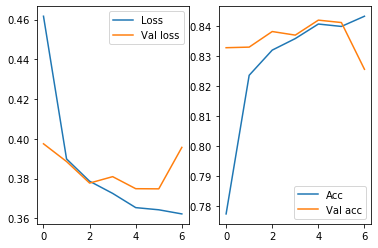

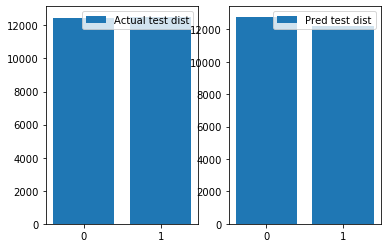

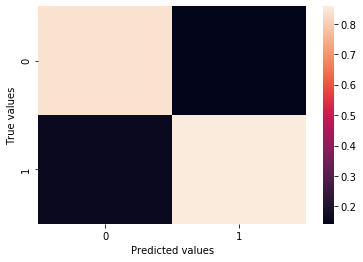

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85     12474
         1.0       0.86      0.84      0.85     12526

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Test accuracy: 0.84808


In [59]:
model = create_model_ff(nodes1=nn_grid_result.best_params_['nodes1'],
                       nodes2=nn_grid_result.best_params_['nodes2'],
                       dropout_rate=nn_grid_result.best_params_['dropout_rate'],
                       learning_rate=nn_grid_result.best_params_['learning_rate'],
                       optimizer=nn_grid_result.best_params_['optimizer'])

earlystop = EarlyStopping(monitor='val_acc',
                          patience=2,
                          restore_best_weights=True)
                         
history = model.fit(x_train, y_train,
                    validation_split=0.2,
                    epochs=1000000,
                    batch_size=nn_grid_result.best_params_['batch_size'],
                    callbacks=[earlystop],
                    verbose=1)

plot_results_nn(history, 
                model,
                x_test,
                y_test,
                save=True,
                name='nn_n1{}_n2{}_dr{}_lr{}'.format(nn_grid_result.best_params_['nodes1'],
                                                     nn_grid_result.best_params_['nodes2'],
                                                     nn_grid_result.best_params_['dropout_rate'],
                                                     nn_grid_result.best_params_['learning_rate']))

### Neural Network - GloVe embeddings as embedded layer
Similar to the previous neural network, but with an embedded layer that is trained together with the weights in the feed-forward network. This does however take a lot longer to train, so the found hyper parameters for the previous section with static embeddings are assumed to be good enough for this model.

In [60]:
# Create functions for custom 'MergeEmedding'-layer which averages 
# the embeddings over all words after the embedding layer 
def merge_embeddings(x):
    # Sum the embeddings for every word slot. If this is zero, there is no word in this slot
    non_zero = K.sum(K.cast(K.not_equal(K.sum(x,axis=2),0),tf.float32))
    return K.sum(x,axis=1) / non_zero

def merge_output_shape(input_shape):
    return input_shape[0], input_shape[-1]

def create_model_emb_ff(nodes1=100, nodes2=50, dropout_rate=0.3, optimizer='rmsprop', learning_rate=0.001):
    if optimizer.lower() == 'rmsprop': 
        optimizer = RMSprop(learning_rate = learning_rate)
    elif optimizer.lower() == 'adam':
        optimizer = Adam(learning_rate = learning_rate)
    model = Sequential() 
    model.add(Embedding(input_dim=vocab_size+1,
                        output_dim=300,
                        mask_zero=True,
                        weights=[trainable_embeddings]))
    model.add(Lambda(merge_embeddings, output_shape=merge_output_shape))
    if nodes1 == 0: 
        model.add(Dense(1, input_shape=x_train.shape[1:], activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model 
    model.add(Dense(nodes1, input_shape=x_train.shape[1:]))
    model.add(Dropout(dropout_rate))
    if nodes2 == 0: 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model
    model.add(Dense(nodes2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    return model 

Train on 20000 samples, validate on 5000 samples
Epoch 1/100000
20000/20000 [==============================] - 83s 4ms/sample - loss: 0.5063 - acc: 0.7307 - val_loss: 0.3336 - val_acc: 0.8652
Epoch 2/100000
20000/20000 [==============================] - 74s 4ms/sample - loss: 0.2793 - acc: 0.8885 - val_loss: 0.3176 - val_acc: 0.8734
Epoch 3/100000
20000/20000 [==============================] - 77s 4ms/sample - loss: 0.2346 - acc: 0.9070 - val_loss: 0.3094 - val_acc: 0.8788
Epoch 4/100000
20000/20000 [==============================] - 78s 4ms/sample - loss: 0.2076 - acc: 0.9196 - val_loss: 0.3140 - val_acc: 0.8782
Epoch 5/100000
20000/20000 [==============================] - 79s 4ms/sample - loss: 0.1904 - acc: 0.9265 - val_loss: 0.3280 - val_acc: 0.8762
Epoch 6/100000
20000/20000 [==============================] - 80s 4ms/sample - loss: 0.1766 - acc: 0.9322 - val_loss: 0.3444 - val_acc: 0.8772
Epoch 7/100000
20000/20000 [==============================] - 79s 4ms/sample - loss: 0.1659 -

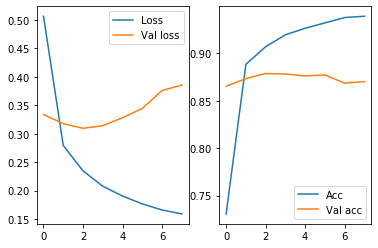

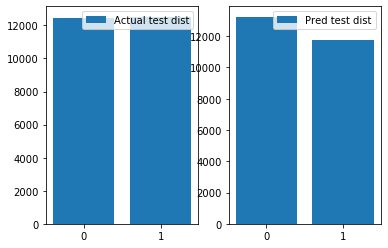

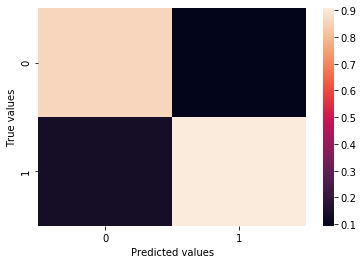

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89     12474
         1.0       0.91      0.85      0.88     12526

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Test accuracy: 0.88176


In [61]:
# Use the same hyper parameters as for static embeddings, too expensive to optimize. 
model_emb = create_model_emb_ff(nodes1=nn_grid_result.best_params_['nodes1'],
                                nodes2=nn_grid_result.best_params_['nodes2'],
                                dropout_rate=nn_grid_result.best_params_['dropout_rate'],
                                learning_rate=nn_grid_result.best_params_['learning_rate'],
                                optimizer=nn_grid_result.best_params_['optimizer'])


earlystop = EarlyStopping(monitor='val_acc',
                          patience=5,
                          restore_best_weights=True)
                         

emb_history = model_emb.fit(x_train_pad, y_train,
                            validation_split=0.2,
                            epochs=100000,
                            batch_size=nn_grid_result.best_params_['batch_size'],
                            verbose=1,
                            callbacks=[earlystop])

plot_results_nn(emb_history, model_emb,x_test_pad, y_test,
                save=True,
                name='nn_emb_n1{}_n2{}_dr{}_lr'.format(nn_emb_grid_result.best_params_['nodes1'],
                                                       nn_emb_grid_result.best_params_['nodes2'],
                                                       nn_emb_grid_result.best_params_['dropout_rate'],
                                                       nn_emb_grid_result.best_params_['learning_rate']))

In [63]:
n_lstm1 = 128
dr_rate = 0.3
learning_rate = 1e-4
optimizer = RMSprop(learning_rate=learning_rate)

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size+1,
                        output_dim=300,
                        mask_zero=True,
                        weights=[trainable_embeddings],
                       trainable=True))
lstm_model.add(Bidirectional(LSTM(n_lstm1, recurrent_dropout=0.2)))
lstm_model.add(Dropout(dr_rate))
lstm_model.add(Dense(1,activation='sigmoid'))

lstm_model.compile(optimizer=optimizer, metrics=['acc'], loss='binary_crossentropy')
lstm_model.summary()

Model: "sequential_280"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 300)         1500300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_403 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_682 (Dense)            (None, 1)                 257       
Total params: 1,939,853
Trainable params: 1,939,853
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history = lstm_model.fit(x_train_pad, y_train,
                              batch_size=64,
                              validation_split=0.2,
                              epochs=1000000,
                              callbacks=[EarlyStopping(monitor='val_acc',
                                                       patience=3,
                                                       restore_best_weights=True)])
save = False

if save: 
    plot_results_nn(lstm_history, lstm_model, x_test_pad, y_test,save=save,
                    name='lstm_l1{}_d{}_dr{}'.format(n_lstm1,n_lstm2,dr_rate))
else: 
    plot_results_nn(lstm_history, lstm_model, x_test_pad, y_test)

Train on 20000 samples, validate on 5000 samples
Epoch 1/1000000
20000/20000 [==============================] - 29233s 1s/sample - loss: 0.6775 - acc: 0.5663 - val_loss: 0.6471 - val_acc: 0.6390
Epoch 2/1000000
20000/20000 [==============================] - 20726s 1s/sample - loss: 0.6013 - acc: 0.6769 - val_loss: 0.5950 - val_acc: 0.6742
Epoch 3/1000000
 2240/20000 [==>...........................] - ETA: 7:31:36 - loss: 0.5295 - acc: 0.7429

In [392]:
n_gru1 = 128
dr_rate = 0.3

gru_model = Sequential()
gru_model.add(Embedding(input_dim=vocab_size+1,
                        output_dim=300,
                        mask_zero=True,
                        weights=[trainable_embeddings],
                       trainable=True))
gru_model.add(Bidirectional(GRU(n_gru1, recurrent_dropout=0.2)))
gru_model.add(Dropout(dr_rate))
gru_model.add(Dense(1,activation='sigmoid'))

gru_model.compile(optimizer='rmsprop', metrics=['acc'], loss='binary_crossentropy')
gru_model.summary()

Model: "sequential_368"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 300)         1500300   
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 40)          38640     
_________________________________________________________________
dropout_694 (Dropout)        (None, None, 40)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 40)                7440      
_________________________________________________________________
dropout_695 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_1394 (Dense)           (None, 50)                2050      
_________________________________________________________________
dropout_696 (Dropout)        (None, 50)             

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 1756s 88ms/sample - loss: 0.5988 - acc: 0.6631 - val_loss: 0.4256 - val_acc: 0.7984
Epoch 2/4
20000/20000 [==============================] - 3969s 198ms/sample - loss: 0.3425 - acc: 0.8535 - val_loss: 0.3199 - val_acc: 0.8628
Epoch 3/4
20000/20000 [==============================] - 2154s 108ms/sample - loss: 0.2344 - acc: 0.9098 - val_loss: 0.3024 - val_acc: 0.8784
Epoch 4/4
20000/20000 [==============================] - 2145s 107ms/sample - loss: 0.1832 - acc: 0.9322 - val_loss: 0.2942 - val_acc: 0.8848


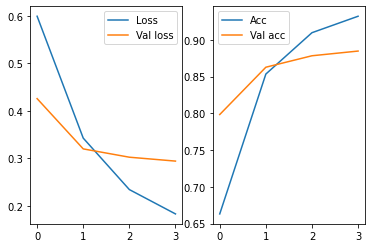

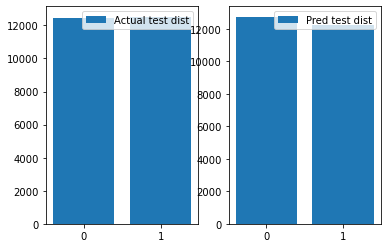

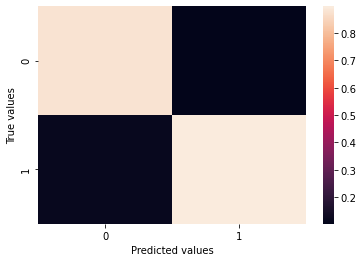

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89     12474
         1.0       0.90      0.88      0.89     12526

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Test accuracy: 0.88832


In [393]:
gru_history = gru_model.fit(x_train_pad, y_train,
                            batch_size=64,
                            validation_split=0.2,
                            epochs=10000,
                            callbacks=[EarlyStopping(monitor='val_acc',patience=3,restore_best_weights=True)])
save = False

if save: 
    plot_results_nn(gru_history, gru_model, x_test_pad, y_test,save=save,
                    name='gru_l{}_dr{}'.format(n_gru1,dr_rate))
else: 
    plot_results_nn(gru_history, gru_model, x_test_pad, y_test)

## Results

The following results were achieved on the independent test set on the IMDB dataset. Pre-trained GloVe-embeddings were used and 

| Model |  Test Accuracy (%) | Hyperparameters |
| :----- | --------------- | --- | 
| Random Classifier | 50.3 | N/A |
| Logistic Regression | 85.2  | N/A |
| Linear Discriminant Analysis | 85.3  | N/A |
| Support Vector Machine | 84.1 | N/A |
| Random Forest | 80.9  | n_estimators=5000, max_depth=50 |
| XGBoost | __86.1__ | n_estimators=500 |
| Multi Layer Perceptron (Pre-trained) | 85.2 | batch_size=16,depth=3,dropout_rate=0.2,nodes=250 |
| Multi Layer Perceptron (Cont. training) |  | batch_size=16,depth=3,dropout_rate=0.2,nodes=250 |
| LSTM | | n_lstm1=20, n_lstm2=20, nodes=50,dropout_rate=0.3 | 

XGBoost gives the best performance on the test set when using GloVe-embeddings. The LSTM-approach takes a lot longer to train, and it is therefore harder to conduct a decent hyperparameter search. The LSTM is the only approach that takes the order of the words into account, which could potentially give a better performance if optimized well.

For comparison, the table below displays state-of-the-art models for the IMDB classification task. 

| Model |	Accuracy (%) |	Paper / Source|
|:----- | ---------- | -------------- |  
| XLNet (Yang et al., 2019) |	__96.21__ |	XLNet: Generalized Autoregressive Pretraining for Language Understanding|
| BERT_large+ITPT (Sun et al., 2019) 	|95.79 |	How to Fine-Tune BERT for Text Classification?|
| BERT_base+ITPT (Sun et al., 2019) |	95.63 |	How to Fine-Tune BERT for Text Classification?|
| ULMFiT (Howard and Ruder, 2018) |	95.4 |	Universal Language Model Fine-tuning for Text Classification|
| Block-sparse LSTM (Gray et al., 2017) |	94.99 |	GPU Kernels for Block-Sparse Weights|
| oh-LSTM (Johnson and Zhang, 2016)| 	94.1| 	Supervised and Semi-Supervised Text Categorization using LSTM for Region Embeddings |
| Virtual adversarial training (Miyato et al., 2016) |	94.1 	|Adversarial Training Methods for Semi-Supervised Text Classification |
| BCN+Char+CoVe (McCann et al., 2017) |	91.8 |	Learned in Translation: Contextualized Word Vectors |

